In [1]:
import matplotlib.pyplot as plt
import numpy as np
import flet as ft
import os
from pylsl import StreamInlet, resolve_stream
from scipy.signal import welch, spectrogram
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, accuracy_score
import pandas as pd
from joblib import dump, load
import pyxdf
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
import seaborn as sns
from keras.models import load_model

Authorization classes are not loaded, using fake implementations.


In [2]:
def create_overlapping_sets(data, set_size=500, overlap_fraction=0.5):
    step = int(set_size * (1 - overlap_fraction))
    sets = []
    for i in range(0, len(data) - set_size + 1, step):
        sets.append(data[i:i + set_size])
    return sets

In [3]:
import numpy as np
from scipy.signal import welch, find_peaks, butter, filtfilt
from sklearn.preprocessing import StandardScaler
from sklearn.cross_decomposition import CCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support

# Define function to calculate PSD
def calculate_psd(data, fs=250, nperseg=250*4):
    f, Pxx = welch(data, fs=fs, nperseg=nperseg)
    return f, Pxx

# Define function to detect peaks
def detect_peaks(Pxx):
    peaks, _ = find_peaks(Pxx)
    return peaks

# Define function for band-pass filtering
def band_pass_filter(data, lowcut, highcut, fs=250, order=5):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    y = filtfilt(b, a, data)
    return y

# Apply band-pass filter and calculate PSD for each dataset
def process_data(data_set):
    filtered_data = [band_pass_filter(epoch, 0.5, 50) for epoch in data_set]
    data_fft = []
    for epoch in filtered_data:
        f, Pxx = calculate_psd(epoch)
        peaks = detect_peaks(Pxx)
        data_fft.append(Pxx[:121])
    return data_fft

In [4]:
streams_test1, header = pyxdf.load_xdf('../../../../data_ssvep/Toey/SSVEP_data/test/6hz_10')
raw_test1 = streams_test1[0]["time_series"].T #From Steam variable this query is EEG data

streams_test2, header = pyxdf.load_xdf('../../../../data_ssvep/Toey/SSVEP_data/test/20hz_10')
raw_test2 = streams_test2[0]["time_series"].T #From Steam variable this query is EEG data

streams_test3, header = pyxdf.load_xdf('../../../../data_ssvep/Toey/SSVEP_data/test/0hz_10')
raw_test3 = streams_test3[0]["time_series"].T #From Steam variable this query is EEG data

In [5]:
data_test1 = raw_test1[0:4,:]
data_test1_oz = data_test1[0] - data_test1[1]
data_test1_o1 = data_test1[2] - data_test1[1]
data_test1_o2 = data_test1[3] - data_test1[1]
data_test1_set_oz = create_overlapping_sets(data_test1_oz, set_size=1000, overlap_fraction=0.5)
data_test1_set_o1 = create_overlapping_sets(data_test1_o1, set_size=1000, overlap_fraction=0.5)
data_test1_set_o2 = create_overlapping_sets(data_test1_o2, set_size=1000, overlap_fraction=0.5)

data_test2 = raw_test2[0:4,:]
data_test2_oz = data_test2[0] - data_test2[1]
data_test2_o1 = data_test2[2] - data_test2[1]
data_test2_o2 = data_test2[3] - data_test2[1]
data_test2_set_oz = create_overlapping_sets(data_test2_oz, set_size=1000, overlap_fraction=0.5)
data_test2_set_o1 = create_overlapping_sets(data_test2_o1, set_size=1000, overlap_fraction=0.5)
data_test2_set_o2 = create_overlapping_sets(data_test2_o2, set_size=1000, overlap_fraction=0.5)

data_test3 = raw_test3[0:4,:]
data_test3_oz = data_test3[0] - data_test3[1]
data_test3_o1 = data_test3[2] - data_test3[1]
data_test3_o2 = data_test3[3] - data_test3[1]
data_test3_set_oz = create_overlapping_sets(data_test3_oz, set_size=1000, overlap_fraction=0.5)
data_test3_set_o1 = create_overlapping_sets(data_test3_o1, set_size=1000, overlap_fraction=0.5)
data_test3_set_o2 = create_overlapping_sets(data_test3_o2, set_size=1000, overlap_fraction=0.5)

In [6]:
# Process each dataset
data1_fft_oz = process_data(data_test1_set_oz)
data1_fft_o1 = process_data(data_test1_set_o1)
data1_fft_o2 = process_data(data_test1_set_o2)

data2_fft_oz = process_data(data_test2_set_oz)
data2_fft_o1 = process_data(data_test2_set_o1)
data2_fft_o2 = process_data(data_test2_set_o2)

data3_fft_oz = process_data(data_test3_set_oz)
data3_fft_o1 = process_data(data_test3_set_o1)
data3_fft_o2 = process_data(data_test3_set_o2)

# Combine the data
combined_data1 = np.hstack((data1_fft_oz, data1_fft_o1, data1_fft_o2))
combined_data2 = np.hstack((data2_fft_oz, data2_fft_o1, data2_fft_o2))
combined_data3 = np.hstack((data3_fft_oz, data3_fft_o1, data3_fft_o2))

# Combine all data
combined_test = np.vstack((combined_data1, combined_data2, combined_data3))

# Create labels for each class
labels_test = np.array([0]*len(data1_fft_oz) + [1]*len(data2_fft_oz) + [2]*len(data3_fft_oz))

# Check that the combined data and labels have the correct shape
print(f"Combined data shape: {combined_test.shape}")
print(f"Labels shape: {labels_test.shape}")

Combined data shape: (83, 363)
Labels shape: (83,)


In [7]:
# cca_model_ml = load('../final/model_P_CCA/cca_model_ml.joblib')

In [8]:
# # Canonical Correlation Analysis (CCA)
# cca = CCA(n_components=1)  
# combined_data_cca = cca.fit_transform(combined_test, labels_test)



# # For each array in the tuple, access and perform a flat transformation.
# combined_data_flat = np.hstack([arr.reshape(-1, 1) for arr in combined_data_cca])

# # Features Normalization
# scaler = StandardScaler()
# combined_test = scaler.fit_transform(combined_data_flat)
# # Save the trained CCA model

# print(combined_test.shape)

# Load trained CCA model
cca_model_ml = load('../final/model_P_CCA/cca_model_ml.joblib')

# Transform data using loaded CCA model
combined_data_cca = cca_model_ml.transform(combined_test)

# Features Normalization
scaler = StandardScaler()
combined_test_use = scaler.fit_transform(combined_data_cca)

# Combine with the original data
combined_test = np.hstack((combined_test_use, combined_test_use))


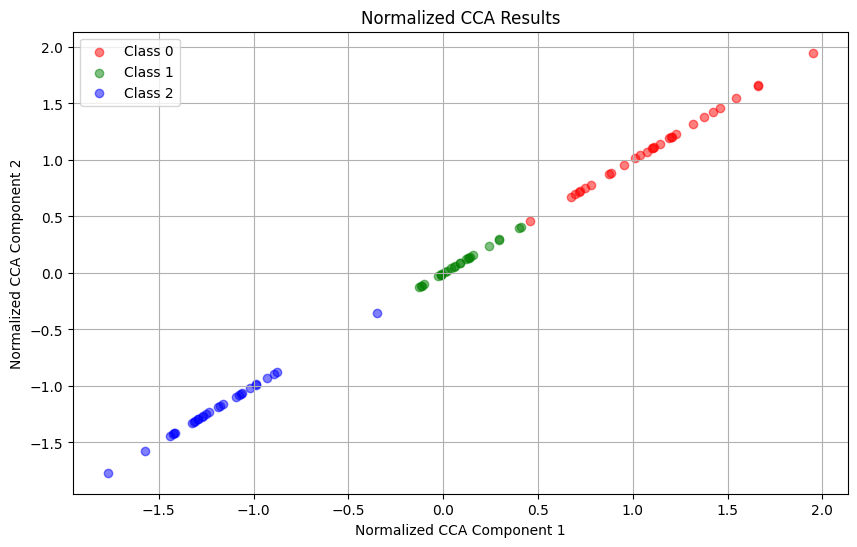

In [9]:
# Plot the CCA results
plt.figure(figsize=(10, 6))


# Assuming labels_test are provided as an array with the same length as the data
classes = np.unique(labels_test)
colors = ['r', 'g', 'b']  # Assigning a color for each class

for i, cls in enumerate(classes):
    plt.scatter(combined_test[labels_test == cls, 0], combined_test[labels_test == cls, 1], 
                color=colors[i], label=f'Class {cls}', alpha=0.5)

plt.xlabel('Normalized CCA Component 1')
plt.ylabel('Normalized CCA Component 2')
plt.title('Normalized CCA Results')
plt.legend()
plt.grid(True)
plt.show()


In [10]:
rf_model = load("../final/model_P_CCA/best_rf_classifier.joblib")
svm_model = load("../final/model_P_CCA/best_svm_classifier.joblib")
lda_model = load("../final/model_P_CCA/best_lda_classifier.joblib")
knn_model = load("../final/model_P_CCA/best_knn_classifier.joblib")


In [11]:
y_pred_rf_test = rf_model.predict(combined_test)
y_pred_svm_test = svm_model.predict(combined_test)
y_pred_lda_test = lda_model.predict(combined_test)
y_pred_knn_test = knn_model.predict(combined_test)

Evaluation metrics for Random Forest:
         Class  Precision    Recall  F1-score  Accuracy
0          0.0   1.000000  0.965517  0.982456  1.000000
1          1.0   0.925926  1.000000  0.961538  0.925926
2          2.0   1.000000  0.965517  0.982456  1.000000
average    NaN   0.977689  0.975904  0.976156  0.975309

[[28  1  0]
 [ 0 25  0]
 [ 0  1 28]]


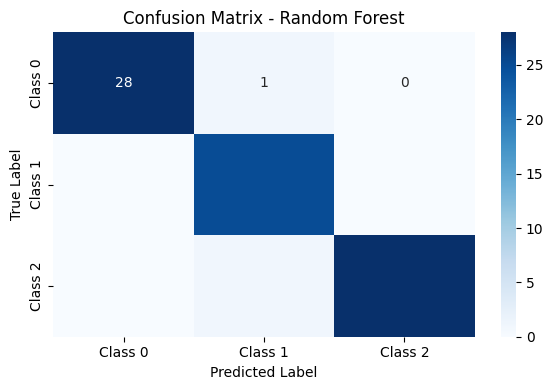

Evaluation metrics for SVM:
         Class  Precision    Recall  F1-score  Accuracy
0          0.0   1.000000  0.965517  0.982456  1.000000
1          1.0   0.925926  1.000000  0.961538  0.925926
2          2.0   1.000000  0.965517  0.982456  1.000000
average    NaN   0.977689  0.975904  0.976156  0.975309

[[28  1  0]
 [ 0 25  0]
 [ 0  1 28]]


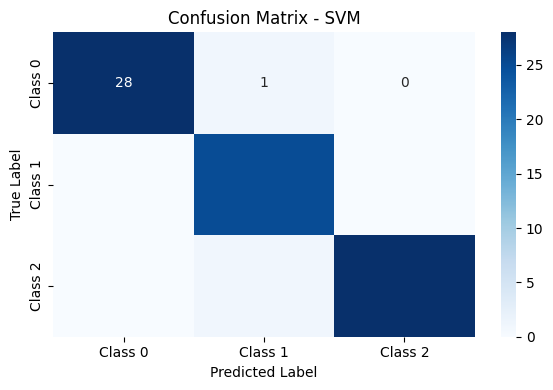

Evaluation metrics for LDA:
         Class  Precision    Recall  F1-score  Accuracy
0          0.0   1.000000  0.965517  0.982456  1.000000
1          1.0   0.925926  1.000000  0.961538  0.925926
2          2.0   1.000000  0.965517  0.982456  1.000000
average    NaN   0.977689  0.975904  0.976156  0.975309

[[28  1  0]
 [ 0 25  0]
 [ 0  1 28]]


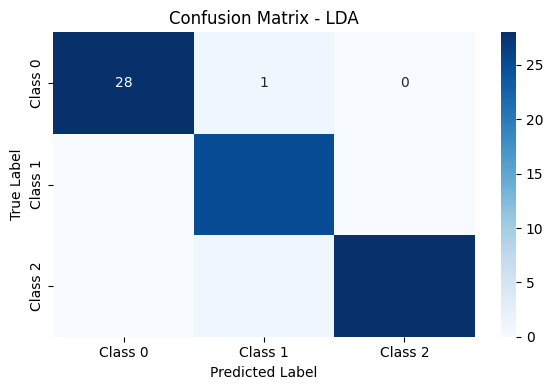

Evaluation metrics for KNN:
         Class  Precision    Recall  F1-score  Accuracy
0          0.0   1.000000  0.965517  0.982456  1.000000
1          1.0   0.925926  1.000000  0.961538  0.925926
2          2.0   1.000000  0.965517  0.982456  1.000000
average    NaN   0.977689  0.975904  0.976156  0.975309

[[28  1  0]
 [ 0 25  0]
 [ 0  1 28]]


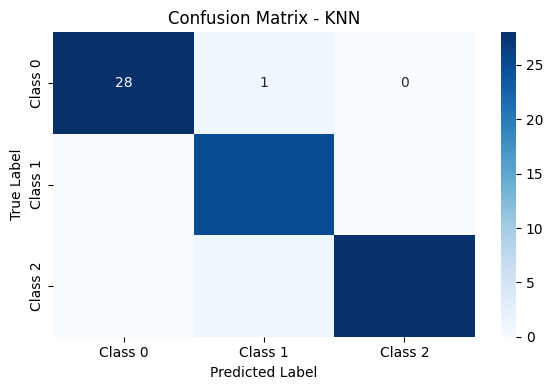

In [12]:
# Define the models and their predictions
models = ['Random Forest', 'SVM', 'LDA', 'KNN']
y_preds = [y_pred_rf_test, y_pred_svm_test, y_pred_lda_test, y_pred_knn_test]

for model, y_pred in zip(models, y_preds):
    # Calculate precision, recall, F1-score, and accuracy per class
    precision_per_class = precision_score(labels_test, y_pred, average=None)
    recall_per_class = recall_score(labels_test, y_pred, average=None)
    f1_per_class = f1_score(labels_test, y_pred, average=None)

    # Calculate accuracy per class
    accuracy_per_class = []
    for class_label in range(len(precision_per_class)):
        correct_predictions = ((y_pred == class_label) & (labels_test == class_label)).sum()
        total_predictions = (y_pred == class_label).sum()
        accuracy = correct_predictions / total_predictions if total_predictions > 0 else 0
        accuracy_per_class.append(accuracy)

    # Calculate average precision, recall, F1-score, and accuracy
    avg_precision = precision_score(labels_test, y_pred, average='weighted')
    avg_recall = recall_score(labels_test, y_pred, average='weighted')
    avg_f1 = f1_score(labels_test, y_pred, average='weighted')

    # Create DataFrame for per-class metrics
    results_per_class_df = pd.DataFrame({
        'Class': range(len(precision_per_class)),
        'Precision': precision_per_class,
        'Recall': recall_per_class,
        'F1-score': f1_per_class,
        'Accuracy': accuracy_per_class
    })

    # Add average metrics to the DataFrame
    results_per_class_df.loc['average'] = [None, avg_precision, avg_recall, avg_f1, np.mean(accuracy_per_class)]

    print(f"Evaluation metrics for {model}:")
    print(results_per_class_df)
    print()

    # Plot confusion matrix
    cm = confusion_matrix(labels_test, y_pred)
    print(cm)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix - {model}')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.xticks(ticks=[0.5, 1.5, 2.5], labels=['Class 0', 'Class 1', 'Class 2'])
    plt.yticks(ticks=[0.5, 1.5, 2.5], labels=['Class 0', 'Class 1', 'Class 2'])
    plt.tight_layout()
    plt.show()

In [13]:
ann_model = load_model("./model_P_CCA/ann_model.h5")
cnn_model = load_model("./model_P_CCA/cnn_model.h5")
lstm_model = load_model("./model_P_CCA/lstm_model.h5")
cnn_scaler = load("./model_P_CCA/cnn_scaler.pkl")
lstm_scaler = load("./model_P_CCA/lstm_scaler.pkl")

In [14]:
# Normalize data with Scaler
scaler = StandardScaler()
combined_test_scaled_cnn = scaler.fit_transform(combined_test)
combined_test_scaled_lstm = scaler.fit_transform(combined_test)
# Adapt data to the format used with the CNN model.
combined_test_reshaped_cnn = combined_test_scaled_cnn.reshape(-1, 2, 1)
# Predict with ANN
y_pred_ann = np.argmax(ann_model.predict(combined_test), axis=1)
# Predict with CNN
y_pred_cnn = np.argmax(cnn_model.predict(combined_test_reshaped_cnn), axis=1)
# Predict with LSTM
combined_test_reshaped_lstm = combined_test_scaled_lstm.reshape(-1, 2, 1)
y_pred_lstm = np.argmax(lstm_model.predict(combined_test_reshaped_lstm), axis=1)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


1/3 ━━━━━━━━━━━━━━━━━━━━ 1s 714ms/stepWARNING:tensorflow:6 out of the last 9 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x000001B39C32E660> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 314ms/step


Evaluation metrics for ANN:
         Class  Precision    Recall  F1-score  Accuracy
0          0.0   1.000000  0.965517  0.982456  1.000000
1          1.0   0.925926  1.000000  0.961538  0.925926
2          2.0   1.000000  0.965517  0.982456  1.000000
average    NaN   0.977689  0.975904  0.976156  0.975309

[[28  1  0]
 [ 0 25  0]
 [ 0  1 28]]


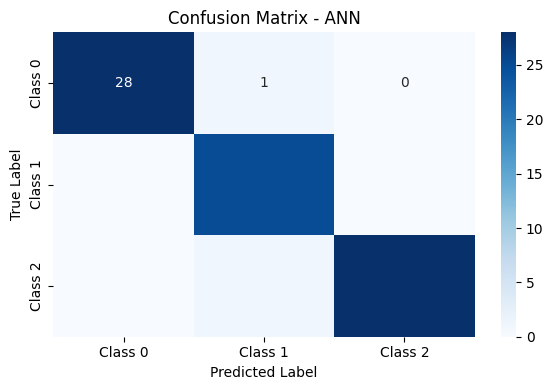

Evaluation metrics for CNN:
         Class  Precision    Recall  F1-score  Accuracy
0          0.0   1.000000  0.965517  0.982456  1.000000
1          1.0   0.925926  1.000000  0.961538  0.925926
2          2.0   1.000000  0.965517  0.982456  1.000000
average    NaN   0.977689  0.975904  0.976156  0.975309

[[28  1  0]
 [ 0 25  0]
 [ 0  1 28]]


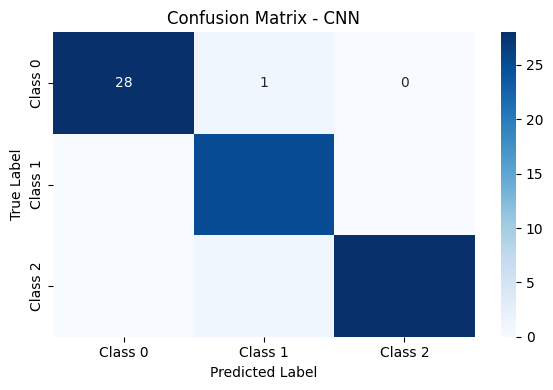

Evaluation metrics for LSTM:
         Class  Precision    Recall  F1-score  Accuracy
0          0.0   1.000000  0.965517  0.982456  1.000000
1          1.0   0.925926  1.000000  0.961538  0.925926
2          2.0   1.000000  0.965517  0.982456  1.000000
average    NaN   0.977689  0.975904  0.976156  0.975309

[[28  1  0]
 [ 0 25  0]
 [ 0  1 28]]


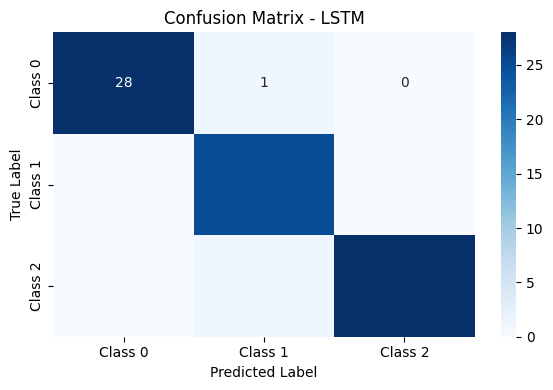

In [15]:
# Define the models and their predictions
models = ['ANN', 'CNN', 'LSTM']
y_preds = [y_pred_ann, y_pred_cnn, y_pred_lstm]

for model, y_pred in zip(models, y_preds):
    # Calculate precision, recall, F1-score, and accuracy per class
    precision_per_class = precision_score(labels_test, y_pred, average=None)
    recall_per_class = recall_score(labels_test, y_pred, average=None)
    f1_per_class = f1_score(labels_test, y_pred, average=None)

    # Calculate accuracy per class
    accuracy_per_class = []
    for class_label in range(len(precision_per_class)):
        correct_predictions = ((y_pred == class_label) & (labels_test == class_label)).sum()
        total_predictions = (y_pred == class_label).sum()
        accuracy = correct_predictions / total_predictions if total_predictions > 0 else 0
        accuracy_per_class.append(accuracy)

    # Calculate average precision, recall, F1-score, and accuracy
    avg_precision = precision_score(labels_test, y_pred, average='weighted')
    avg_recall = recall_score(labels_test, y_pred, average='weighted')
    avg_f1 = f1_score(labels_test, y_pred, average='weighted')

    # Create DataFrame for per-class metrics
    results_per_class_df = pd.DataFrame({
        'Class': range(len(precision_per_class)),
        'Precision': precision_per_class,
        'Recall': recall_per_class,
        'F1-score': f1_per_class,
        'Accuracy': accuracy_per_class
    })

    # Add average metrics to the DataFrame
    results_per_class_df.loc['average'] = [None, avg_precision, avg_recall, avg_f1, np.mean(accuracy_per_class)]

    print(f"Evaluation metrics for {model}:")
    print(results_per_class_df)
    print()

    # Plot confusion matrix
    cm = confusion_matrix(labels_test, y_pred)
    print(cm)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix - {model}')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.xticks(ticks=[0.5, 1.5, 2.5], labels=['Class 0', 'Class 1', 'Class 2'])
    plt.yticks(ticks=[0.5, 1.5, 2.5], labels=['Class 0', 'Class 1', 'Class 2'])
    plt.tight_layout()
    plt.show()